# metagenomeSeq differential abundance analysis script
## 2020-04-13

This script has in essence the same content as CSS.R (with some debugging). The aim is to have the information in a nice-formatted document.

Scripts to reproduce the Figures  of Pérez-Jaramillo et al., 2016  
Differential abundant features analysis using a Zero Inflated Gaussian Model
from Paulson et al, 2013.

Juan Esteban Pérez Jaramillo - Victor J. Carrión  
Netherlands Institute of Ecology  
j.perez@nioo.knaw.nl  
biojep@gmail.com

## Code
Import libraries:

In [1]:
library("mime")
library("httpuv")
library("metagenomeSeq")
library("ggplot2")
library("NetComp")

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; vie

Import data:

In [2]:
getwd()
tmp = loadMeta("Matriz_final_rhizosphere_asv-copia.tsv", sep = "\t") #Cargar tabla de ASVs
taxa = read.delim("taxonomy_final_rhizosphere.tsv", header=TRUE, row.names = 1, stringsAsFactors = FALSE, sep = "\t") #Cargar taxonomía
mapfile = loadPhenoData("metadata_rhizosphere.tsv", tran = TRUE) #Cargar metadatos
phenotypeData = AnnotatedDataFrame(mapfile) #Convertir metadatos
OTUdata = AnnotatedDataFrame(taxa) #Convertir taxonomía
obj = newMRexperiment(tmp$counts, phenoData = phenotypeData, featureData = OTUdata)
head(MRcounts(obj[, 1:36])) #Mirar Columnas#

[1] "/home/nesper/docs/genomeseq/genomeSeq/metagenomeSeq-abund"

,A1_1,A1_2,A1_3,A1_4,A2_1,A2_2,A2_3,A2_4,L1_1,L1_2,⋯,M4_3,M4_4,M5_1,M5_2,M5_3,M5_4,S_1,S_2,S_3,S_4
ASV1,342,239,1076,322,299,437,237,928,566,605,⋯,482,423,824,312,940,455,0,0,0,0
ASV2,354,239,1064,323,300,393,234,905,571,654,⋯,523,417,815,272,984,467,0,0,0,0
ASV3,310,204,878,269,229,335,224,678,436,527,⋯,395,321,658,236,788,382,0,0,0,0
ASV4,252,213,838,251,258,318,207,656,424,526,⋯,349,328,608,256,786,409,0,0,0,0
ASV5,286,226,868,291,242,361,218,663,418,480,⋯,339,293,579,273,784,378,0,0,0,0
ASV6,236,205,694,254,201,257,152,524,379,442,⋯,279,278,558,202,651,296,0,0,0,0


Calculating the normalization factors:

Default value being used.

Default value being used.



[1] "A1"   "A2"   "L1"   "M1"   "M2"   "M3"   "M4"   "M5"   "Soil"

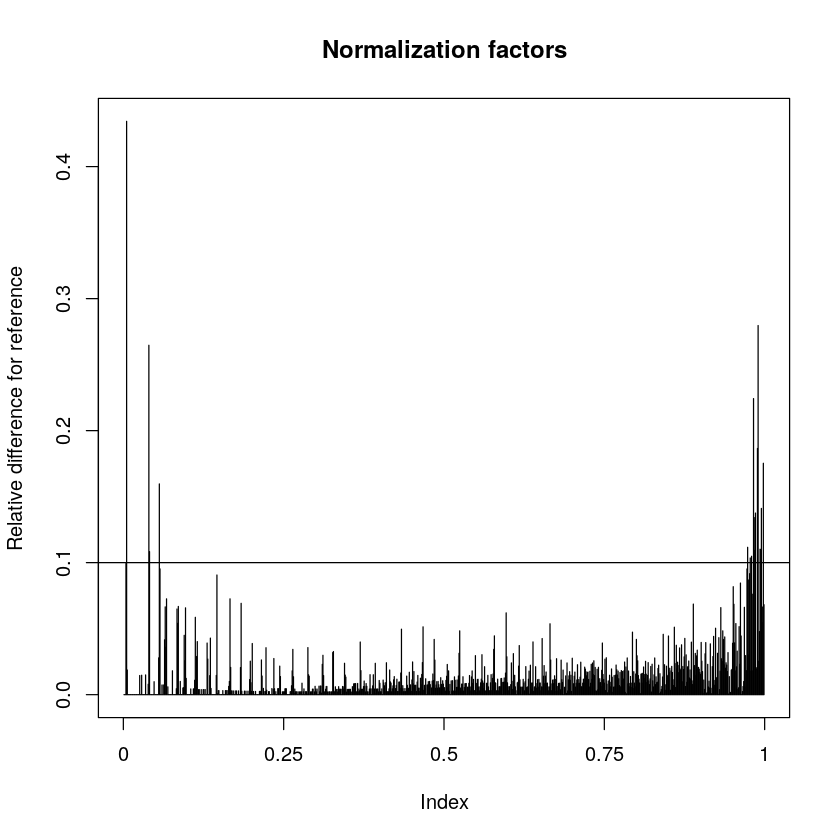

In [3]:
p2 = cumNormStat(obj, pFlag = TRUE, main = "Normalization factors")
obj = cumNorm(obj, p = cumNormStatFast(obj))
normFactor = normFactors(obj)
normFactor = log2(normFactor/median(normFactor) + 1)
settings = zigControl(maxit = 10, verbose = TRUE) #Configuration for fitZig function, maxit: maximum iterations
Accession = pData(obj)$Accession
mod = model.matrix(~Accession)
colnames(mod) = levels(Accession)
colnames(mod)

Normalization to export:

In [4]:
mat = MRcounts(obj, norm = TRUE, log = TRUE)
#mat #See created object

Exporting Normalization:
```
exportMat(mat, file = file.path("CSS_normalized_spermosphere2.txt")) #Colocar la ruta y el nombre del archivo#
```

In [5]:
res = fitZig(obj = obj, mod = mod, useCSSoffset = TRUE, control = settings)
zigFit = res@fit
finalMod = res@fit$design

it= 0, nll=42.34, log10(eps+1)=Inf, stillActive=13833
it= 1, nll=36.21, log10(eps+1)=0.08, stillActive=13364
it= 2, nll=46.93, log10(eps+1)=0.05, stillActive=888
it= 3, nll=47.53, log10(eps+1)=0.05, stillActive=118
it= 4, nll=47.59, log10(eps+1)=0.06, stillActive=22
it= 5, nll=47.61, log10(eps+1)=0.00, stillActive=1
it= 6, nll=47.62, log10(eps+1)=0.00, stillActive=0


Make contrast between samples:

In [8]:
contrast.matrix = makeContrasts(A1 - M1, levels = finalMod)
fit2 = contrasts.fit(zigFit, contrast.matrix)
fit3 = eBayes(fit2)
topTable(fit3, coef="A1 - M1")

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ASV2,13.67304,7.7531930,38.03023,1.991087e-304,2.754271e-300,710.3454
ASV1,13.64667,7.7590198,37.95685,2.632808e-303,1.820982e-299,707.5799
ASV2271,21.33899,0.6285274,37.22533,3.151313e-292,1.453070e-288,672.3713
ASV3,13.17404,7.5266640,36.64232,1.568538e-283,5.424398e-280,658.9413
ASV5,12.97495,7.4901517,36.08860,2.218889e-275,6.138779e-272,638.9665
ASV7,12.76860,7.2247151,35.51459,4.812270e-267,1.109469e-263,618.5805
ASV8,12.72985,7.1819489,35.40701,1.705392e-265,3.370098e-262,614.7962
ASV9,12.68032,7.1677492,35.26908,1.630856e-263,2.819954e-260,609.9611
ASV6,12.64572,7.2275060,35.17309,3.861997e-262,5.935890e-259,606.6075


In [9]:
res <- topTable(fit3,coef=1,adjust="BH",n=Inf)
head(res)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ASV2,13.67304,7.7531930,38.03023,1.991087e-304,2.754271e-300,710.3454
ASV1,13.64667,7.7590198,37.95685,2.632808e-303,1.820982e-299,707.5799
ASV2271,21.33899,0.6285274,37.22533,3.151313e-292,1.453070e-288,672.3713
ASV3,13.17404,7.5266640,36.64232,1.568538e-283,5.424398e-280,658.9413
ASV5,12.97495,7.4901517,36.08860,2.218889e-275,6.138779e-272,638.9665
ASV7,12.76860,7.2247151,35.51459,4.812270e-267,1.109469e-263,618.5805


In [10]:
res[,6] = ifelse(res$adj.P.Val > 0.05,"gray", ifelse(res$logFC > -0 & res$logFC > 0,"green", "red")) #green, red, firebrick2, gold2, dodgerblue3, green4
size <- ifelse((res$adj.P.Val < 0.05 & abs(res$logFC) > 0), 4, 2)

To save results:
```
write.table((res),"/<path>/A1-vs-M1.txt")```
Construct the plot object:

Warning message:
“Use of `res$P.Val` is discouraged. Use `P.Val` instead.”
Warning message:
“Removed 2190 rows containing missing values (geom_point).”


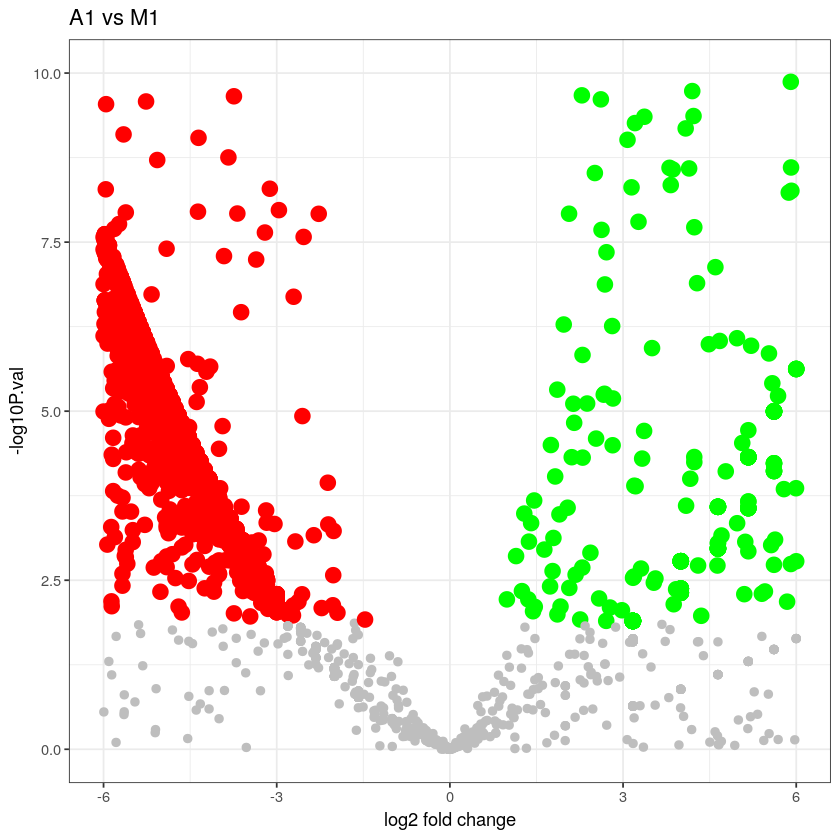

In [13]:
g <- ggplot(data=res, aes(x=res[,1], y=-log10(res$P.Val))) +
  geom_point(size=size, colour=res[,6]) +
  theme_bw() + 
  xlim(c(-6, 6)) + ylim(c(0,10)) +
  xlab("log2 fold change") + ylab("-log10P.val") +
  guides(colour = guide_legend(override.aes = list(shape=16))) + 
  labs(title = "A1 vs M1")
g